In [1]:
import pandas as pd
from modules import constants
from modules.functions import convert_box_score_dataframe_to_regression_format,add_calculated_metrics_to_preprocessed_dataframe
from modules.functions import generate_expected_efficiencies_verbose,generate_expected_efficiencies
from modules.objects import Team,Game
from sklearn.linear_model import Ridge
from modules.objects import RegressionHub
team_id_name_dict = {v:k for k,v in constants.TEAM_NAME_ID_DICT.items()}
from datetime import datetime
today = str(datetime.today()).split(" ")[0]

Read in full data filter on D1 games only

In [2]:
full_box_df = pd.read_parquet('parquet_files/box_scores_sports_reference_2024.gzip')
metrics_df = add_calculated_metrics_to_preprocessed_dataframe(full_box_df)
reg_df = convert_box_score_dataframe_to_regression_format(metrics_df)
print(reg_df.shape)
games_df = reg_df.drop(['ortg','drtg','pace','to_pct','opp_to_pct','game_date','ui'],axis = 1).copy()
y_df = reg_df[['ortg','drtg','pace']].copy()

parameter_dict = {}
master_df = pd.DataFrame()
for column in y_df.columns.tolist():
    
    reg = Ridge(alpha=1.5,fit_intercept=True)
    reg.fit(X = games_df ,y = y_df[column].to_numpy())
    reg_results = {"variable":[],f'coef_{column}':[],f'intercept_{column}':[],f'adj_{column}':[]}
    intercept = round(reg.intercept_,2)
    parameter_dict[f"{column}_regression"] = reg
    
    for variable,coefficient in zip(games_df.columns,reg.coef_):
        reg_results[f'intercept_{column}'].append(intercept)
        reg_results['variable'].append(variable)
        reg_results[f'coef_{column}'].append(coefficient)
        reg_results[f'adj_{column}'].append(coefficient + reg.intercept_)
    
    output_df = pd.DataFrame(reg_results)
    output_df = output_df.loc[(output_df.variable.str.startswith("TM")) | (output_df.variable == "home")].copy()
    output_df['tm_id'] = output_df.variable.map(lambda x: x.split("_")[1] if x != 'home' else -1).astype(int)
    output_df['team_name'] = output_df.tm_id.map(lambda x: team_id_name_dict.get(x,"HOME_COURT_ADVANTAGE"))
    output_df = output_df[['team_name',f'intercept_{column}',f'coef_{column}',f'adj_{column}']]
    
    if master_df.empty:
        master_df = output_df.copy()
        continue
    
    master_df = master_df.merge(output_df,on = 'team_name')
    

master_df['adj_nrtg'] = master_df.adj_ortg - master_df.adj_drtg
parameter_dict['regression_dict'] = master_df.set_index('team_name').to_dict(orient='index')

master_df.to_parquet(f'outputs/adjusted_rankings/adjusted_rankings_{today}.gzip',compression='gzip',index = False)
master_df.sort_values('adj_nrtg',ascending=False).reset_index(drop = True)

(11294, 732)


,team_name,intercept_ortg,coef_ortg,adj_ortg,intercept_drtg,coef_drtg,adj_drtg,intercept_pace,coef_pace,adj_pace,adj_nrtg
0,HOUSTON,104.74,12.815196,117.557516,104.74,-20.678841,84.063480,68.79,-4.082817,64.704895,33.494037
1,UCONN,104.74,20.405853,125.148174,104.74,-11.652470,93.089851,68.79,-3.109025,65.678687,32.058323
2,PURDUE,104.74,19.873649,124.615970,104.74,-11.228158,93.514163,68.79,-0.685168,68.102543,31.101807
3,ARIZONA,104.74,15.727060,120.469381,104.74,-13.633735,91.108586,68.79,4.473965,73.261677,29.360795
4,AUBURN,104.74,14.453180,119.195501,104.74,-12.570869,92.171451,68.79,2.228777,71.016489,27.024049
...,...,...,...,...,...,...,...,...,...,...,...
358,HOUSTON CHRISTIAN,104.74,-12.213570,92.528750,104.74,11.933294,116.675615,68.79,4.895751,73.683463,-24.146864
359,PACIFIC,104.74,-12.747549,91.994772,104.74,13.054792,117.797113,68.79,0.688266,69.475978,-25.802341
360,COPPIN STATE,104.74,-20.880781,83.861540,104.74,5.661404,110.403725,68.79,-1.031641,67.756071,-26.542185
361,IUPUI,104.74,-13.590110,91.152211,104.74,13.708584,118.450905,68.79,-0.046042,68.741670,-27.298694


In [3]:
hub = RegressionHub(**parameter_dict)
print(hub.ortg_regression.intercept_,hub.drtg_regression.intercept_,hub.pace_regression.intercept_)

104.74232086175932 104.74232086175935 68.78771179239094


In [4]:
games_df['expected_ortg'] = hub.ortg_regression.predict(games_df.iloc[:,:725])
games_df['actual_ortg'] = y_df.ortg
games_df['expected_drtg'] = hub.drtg_regression.predict(games_df.iloc[:,:725])
games_df['actual_drtg'] = y_df.drtg
games_df['expected_pace'] = hub.pace_regression.predict(games_df.iloc[:,:725])
games_df['actual_pace'] = y_df.pace
games_df['actual_nrtg'] = games_df.actual_ortg - games_df.actual_drtg
games_df['expected_nrtg'] = games_df.expected_ortg - games_df.expected_drtg
games_df['ui'] = metrics_df.ui

df_to_merge = games_df[[i for i in games_df.columns if (i.startswith('expe')  or i == 'ui')]].copy()
metrics_df = metrics_df.merge(df_to_merge, on='ui').round(2)
metrics_df.to_parquet(f'outputs/boxscores_with_expected_values/ev_{today}',compression='gzip',index=False)

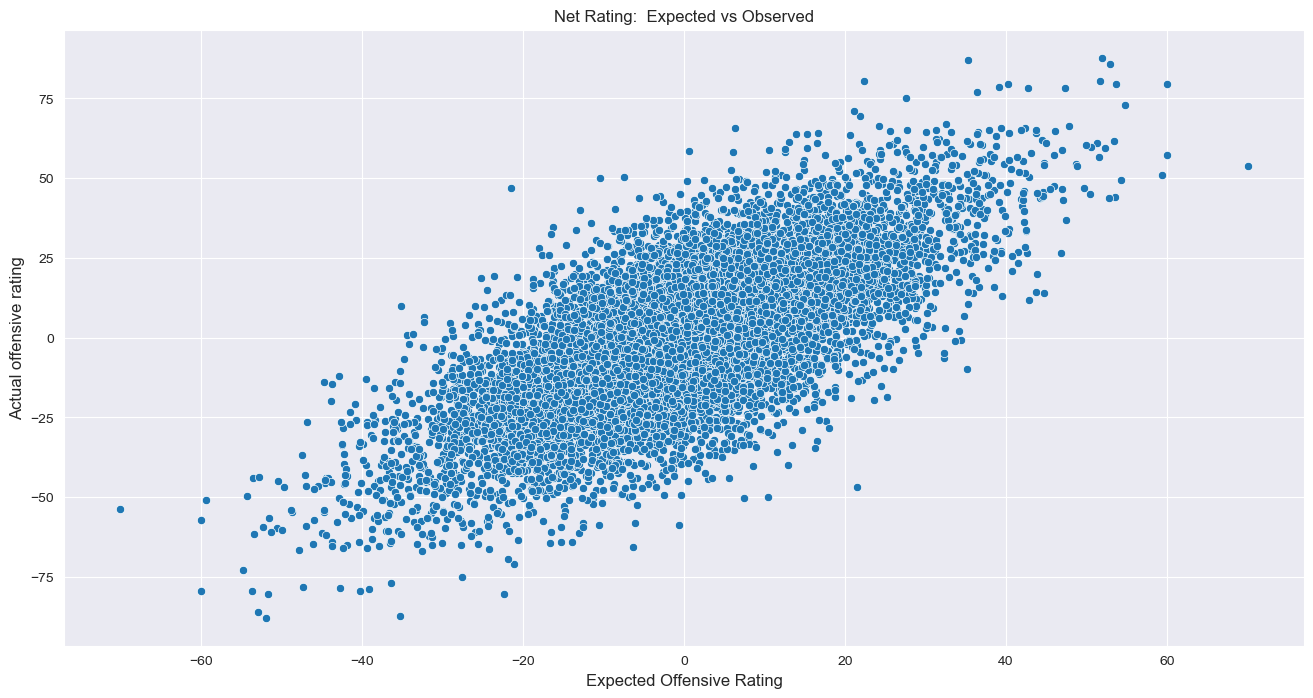

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.scatterplot(x = games_df.expected_nrtg,y = games_df.actual_nrtg)
plt.title("Net Rating:  Expected vs Observed")
plt.xlabel("Expected Offensive Rating",size = 12)
plt.ylabel("Actual offensive rating",size = 12)
plt.show();

,Percentage_Of_Games_Won
Illinois,0.87747
Morehead State,0.12253


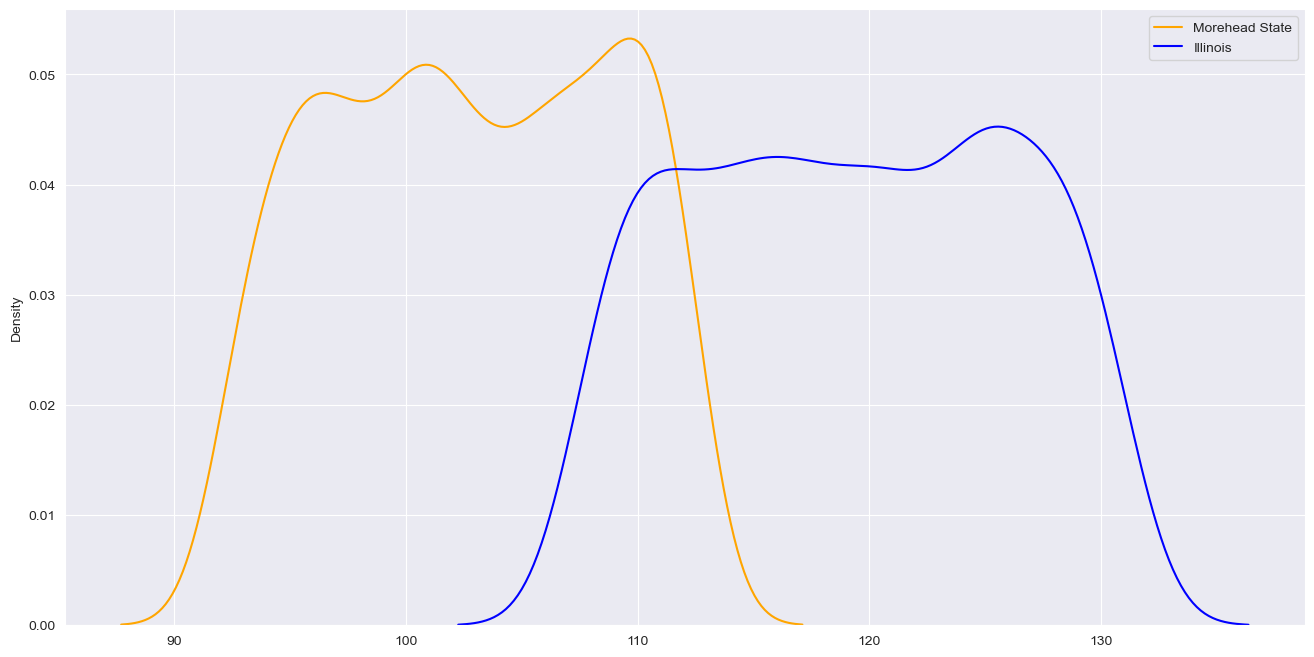

67.5


In [6]:
import numpy as np
def analyze_matchup(reg_output_dict: dict,
                    team_1:str,
                    team_2:str,
                    home_team: str = None
                    ) -> None:
    
    # Housekeeping
    for team in [team_1, team_2]:
        if team is None:
            continue
        if team.upper() in reg_output_dict:
            continue
        raise ValueError(f"'{team.upper()}' is not a recognized team name")
    
    # Create output arrays
    winner_array = []
    score_array = []
    winner_append = winner_array.append
    score_append = score_array.append
    
    team_1_expected_efficiency,team_2_expected_efficiency,expected_pace = generate_expected_efficiencies(reg_output_dict,
                                                                                                         team_1,
                                                                                                         team_2,
                                                                                                         home_team=home_team)
    
    
    team_1_obj,team_2_obj = Team(team_1,team_1_expected_efficiency),Team(team_2,team_2_expected_efficiency)
    game =  Game(team_1_obj,team_2_obj,expected_pace)
    
    # Simulate 100,000 games
    for _ in range(100_000):
        outcome = game.play(return_score=True)
        winner_append(outcome[0])
        score_append(outcome[1:])
    
    display(pd.Series(winner_array).value_counts(normalize=True).to_frame("Percentage_Of_Games_Won"))
    
    team_1_trials = [np.random.uniform(team_1_expected_efficiency * 0.9 , team_1_expected_efficiency * 1.1) for _ in range(1000)]
    team_2_trials = [np.random.uniform(team_2_expected_efficiency * 0.9 , team_2_expected_efficiency * 1.1) for _ in range(1000)]
    plt.figure(figsize = (16,8))
    sns.kdeplot(team_1_trials ,color = 'orange')
    sns.kdeplot(team_2_trials ,color = 'blue')
    plt.legend([team_1,team_2])
    plt.show();
    print(expected_pace)

analyze_matchup(parameter_dict['regression_dict'],
                "Morehead State",
                "Illinois")